Municipality Data:


,id,id_secondary,name,tag
0,28183,1837,Zarzalejo,Zarzalejo
1,28070,702,Horcajo de la Sierra-Aoslos,Horcajo de la Sierra-Aoslos
2,28154,1548,Torres de la Alameda,Torres de la Alameda
3,28052,528,Chinchón,Chinchón
4,28074,745,Leganés,Leganés


Demographics Data:


,id_secondary_municipality,name,total,year,range
0,14,Acebeda (La),0,2021,0-4
1,14,Acebeda (La),0,2022,0-4
2,14,Acebeda (La),0,2023,0-4
3,14,Acebeda (La),1,2024,0-4
4,29,Ajalvir,198,2021,0-4


Municipality columns: ['id', 'id_secondary', 'name', 'tag']
Demographics columns: ['id_secondary_municipality', 'name', 'total', 'year', 'range']
Merged columns: ['id_secondary_municipality', 'name_x', 'total', 'year', 'range', 'id', 'id_secondary', 'name_y', 'tag']


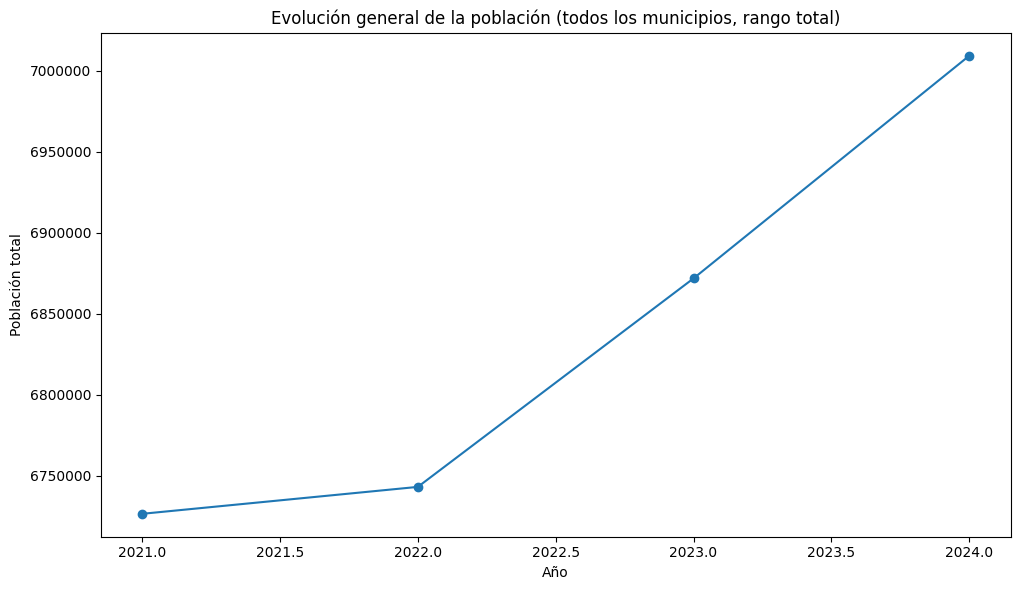

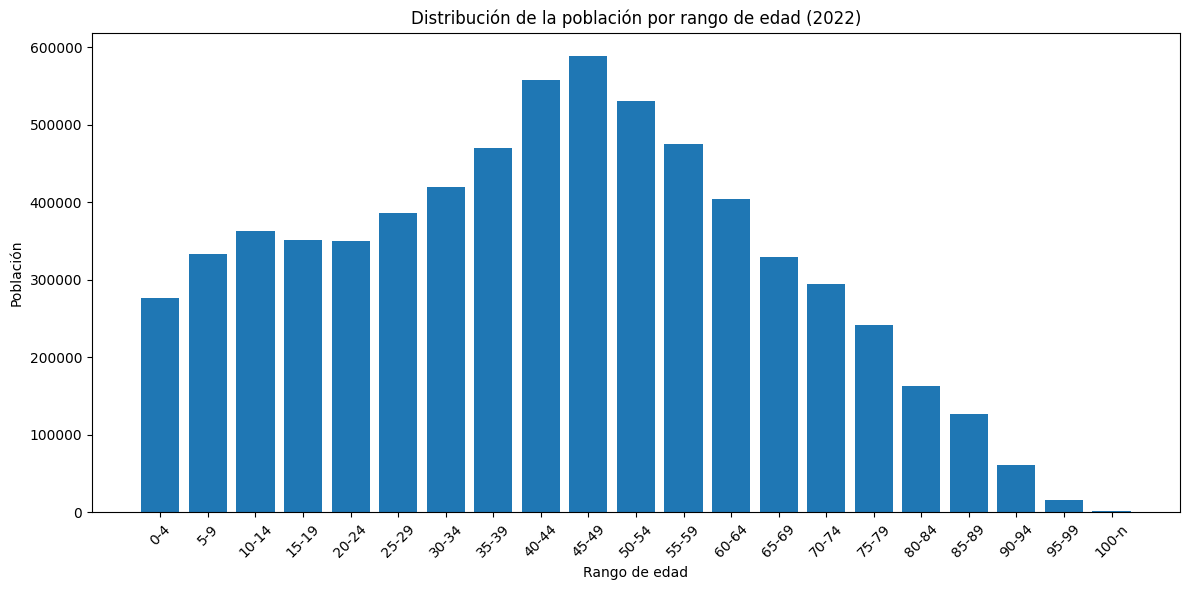

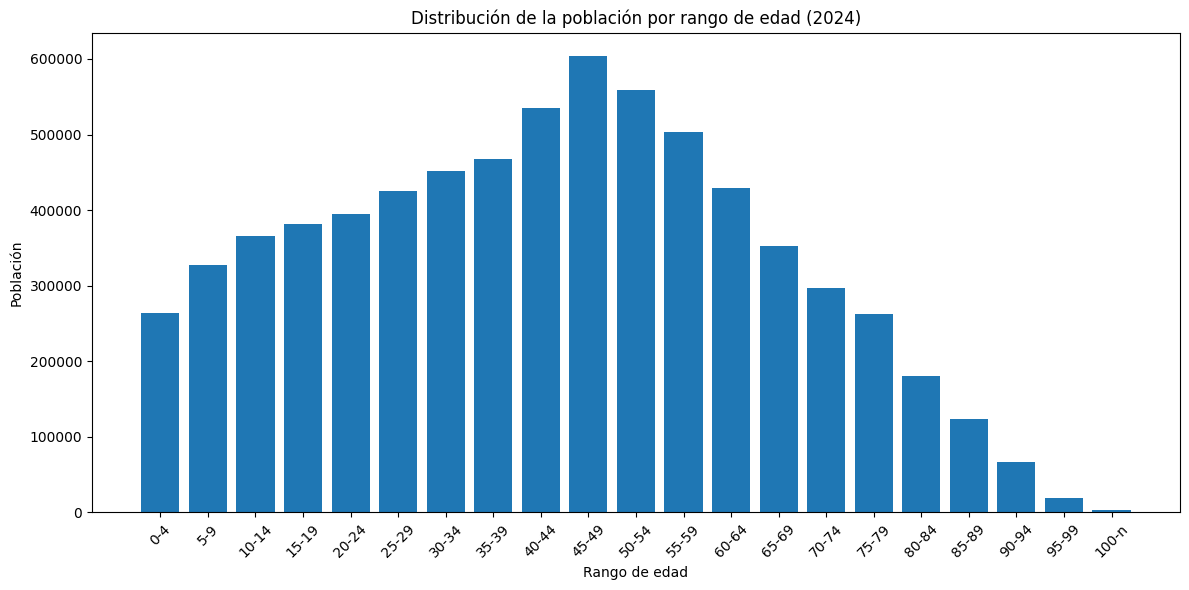

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load municipality metadata
municipality_df = pd.read_csv('../downloads/normalizacion/municipality.csv', delimiter=',')
# Load demographic data (with correct delimiter)
demographics_df = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv', delimiter=',')

# Preview the data
print('Municipality Data:')
display(municipality_df.head())
print('Demographics Data:')
display(demographics_df.head())

# Check the actual column names in both DataFrames
print('Municipality columns:', municipality_df.columns.tolist())
print('Demographics columns:', demographics_df.columns.tolist())

# Fix column names for municipality_df
municipality_df.columns = [c.strip() for c in municipality_df.columns]
if 'id,id_secondary,name,tag' in municipality_df.columns:
    municipality_df = municipality_df.rename(columns={'id,id_secondary,name,tag': 'id_secondary'})

# Merge using correct columns
merged_df = demographics_df.merge(municipality_df, left_on='id_secondary_municipality', right_on='id_secondary', how='left')
print('Merged columns:', merged_df.columns.tolist())

# Use the correct municipality name column for grouping (name_y from municipality_df)
agg_df = merged_df.groupby(['name_y', 'year', 'range'], as_index=False)['total'].sum()

# Convert 'year' to int and 'total' to float for plotting
agg_df['year'] = agg_df['year'].astype(int)
agg_df['total'] = agg_df['total'].astype(float)

# Filter only rows where range == 'total'
agg_df_total = agg_df[agg_df['range'].str.lower() == 'total']

# Get the latest year for each municipality
latest_year = agg_df_total['year'].max()
latest_pop = agg_df_total[agg_df_total['year'] == latest_year]

# Find top 5 municipalities by population in the latest year
top5 = latest_pop.nlargest(5, 'total')
# Find bottom 5 municipalities by population in the latest year
bottom5 = latest_pop.nsmallest(5, 'total')

# 1. Evolución general de la población sumando todos los municipios (solo rango 'total')
pop_evolution = agg_df_total.groupby('year')['total'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(pop_evolution['year'], pop_evolution['total'], marker='o')
plt.xlabel('Año')
plt.ylabel('Población total')
plt.title('Evolución general de la población (todos los municipios, rango total)')
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Define the correct order for age ranges
age_ranges_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90-94", "95-99", "100-n"
]

# 2. Distribución de la población por rangos para 2022 y 2024 (omitiendo rango 'total')
for year in [2022, 2024]:
    df_year = agg_df[(agg_df['year'] == year) & (agg_df['range'].str.lower() != 'total')]
    pop_by_range = df_year.groupby('range')['total'].sum().reset_index()
    # Sort by the defined age range order
    pop_by_range['range'] = pd.Categorical(pop_by_range['range'], categories=age_ranges_order, ordered=True)
    pop_by_range = pop_by_range.sort_values('range')
    plt.figure(figsize=(12, 6))
    plt.bar(pop_by_range['range'], pop_by_range['total'])
    plt.xlabel('Rango de edad')
    plt.ylabel('Población')
    plt.title(f'Distribución de la población por rango de edad ({year})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()
